In [1]:
import os
os.chdir('../')
import torch

from packages import *

from BranchAndBound import BranchAndBound
import pandas as pd
from sklearn.decomposition import PCA, FastICA
import copy
import json
from Utilities.Timer import Timers
import warnings
from tqdm import tqdm
import matplotlib.patches as patches

from Utilities.Plotter import plotReachability
import sys


torch.set_printoptions(precision=8)
warnings.filterwarnings("ignore")

In [2]:
from Bounding.LipschitzBound import LipschitzBounding

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, path, A=None, B=None, c=None, activation='softplus', loadOrGenerate=True, listLayers=None):
        super().__init__()
        self.activation = activation
        if activation == 'softplus':
            activationF = nn.Softplus()
        elif activation == 'sigmoid':
            activationF = nn.Sigmoid()
        elif activation == 'tanh':
            activationF = nn.Tanh()
        else:
            activationF = nn.ReLU()

        if loadOrGenerate:
            stateDictionary = torch.load(path, map_location=torch.device("cpu"))
            layers = []
            for keyEntry in stateDictionary:
                if "weight" in keyEntry:
                    layers.append(nn.Linear(stateDictionary[keyEntry].shape[1], stateDictionary[keyEntry].shape[0]))
                    layers.append(activationF)
            layers.pop()
            self.Linear = nn.Sequential(
                *layers
            )
            self.load_state_dict(stateDictionary)

        else:
            layers = []
            for i in range(len(listLayers)-1):
                layers.append(nn.Linear(listLayers[i], listLayers[i+1]))
                torch.nn.init.xavier_uniform_(layers[-1].weight)
                # layers[-1].weight.data *= 2 / torch.linalg.norm(layers[-1].weight.data, ord=2)
                layers.append(activationF,)
            layers.pop()

            self.Linear = nn.Sequential(*layers)
        
        self.isLinear = True
        self.rotation = nn.Identity()
        self.A = A
        self.B = B
        self.c = c

        if self.A is None:
            dimInp = self.Linear[0].weight.shape[1]
            dimOut = self.Linear[-1].weight.shape[0]
            if False:
                self.A = torch.zeros((dimOut, dimInp)).float()
                self.B = torch.eye(dimOut, dimOut).float()
                self.c = torch.zeros(dimOut).float()
            else:
                self.A = torch.zeros((dimInp, dimInp)).float()
                self.B = torch.ones((dimInp, dimOut)).float()
                self.c = torch.zeros(dimOut).float()


    def load(self, path):
        stateDict = torch.load(path, map_location=torch.device("cpu"))
        self.load_state_dict(stateDict)

    def setRepetition(self, repetition):
        self.repetition = repetition

    def forward(self, x):
        x = self.rotation(x)
        for i in range(self.repetition):
            x = x @ self.A.T + self.Linear(x) @ self.B.T + self.c
        return x

In [4]:
def compareSecondOrderMethods(pcaDirections, config, device, network,
                                originalNetwork, horizonForLipschitz, lowerCoordinate, upperCoordinate,
                                boundingMethod):
    
    virtualBranching = config['virtualBranching']
    numberOfVirtualBranches = config['numberOfVirtualBranches']
    maxSearchDepthLipschitzBound = config['maxSearchDepthLipschitzBound']
    normToUseLipschitz = config['normToUseLipschitz']
    useTwoNormDilation = config['useTwoNormDilation']
    useSdpForLipschitzCalculation = config['useSdpForLipschitzCalculation']
    lipschitzSdpSolverVerbose = config['lipschitzSdpSolverVerbose']

    timers = Timers(["lowerBound",
                        "lowerBound:lipschitzForwardPass", "lowerBound:lipschitzCalc",
                        "lowerBound:lipschitzSearch",
                        "lowerBound:virtualBranchPreparation", "lowerBound:virtualBranchMin",
                        "upperBound",
                        "bestBound",
                        "branch", "branch:prune", "branch:maxFind", "branch:nodeCreation",
                        "LipSDP",
                        ])


        
    lowerBoundClass = LipschitzBounding(network, device, virtualBranching, maxSearchDepthLipschitzBound,
                                                 normToUseLipschitz, useTwoNormDilation, useSdpForLipschitzCalculation,
                                                 numberOfVirtualBranches, lipschitzSdpSolverVerbose,
                                                 [],
                                                 originalNetwork=originalNetwork,
                                                 horizon=horizonForLipschitz,
                                                 boundingMethod=boundingMethod
                                                 )
    
    M1, M2, M3, M4, M5, M6, T = lowerBoundClass.compareSecondOrder(lowerCoordinate.reshape(1, -1), upperCoordinate.reshape(1, -1), pcaDirections[0], timers)
    
    return M1, M2, M3, M4, M5, M6, T[0], T[1]


def main(Method = None):
    configFolder = "Config/"
    fileName = ["RobotArmS", "DoubleIntegratorS", "quadrotorS", "MnistS" , "test"]
    fileName = fileName[2]

    configFileToLoad = configFolder + fileName + ".json"

    with open(configFileToLoad, 'r') as file:
        config = json.load(file)

    eps = config['eps']
    verboseMultiHorizon = config['verboseMultiHorizon']
    normToUseLipschitz = config['normToUseLipschitz']
    useSdpForLipschitzCalculation = config['useSdpForLipschitzCalculation']
    finalHorizon = 1
    performMultiStepSingleHorizon = config['performMultiStepSingleHorizon']
    plotProjectionsOfHigherDims = config['plotProjectionsOfHigherDims']
    onlyPcaDirections = config['onlyPcaDirections']
    pathToStateDictionary = config['pathToStateDictionary']
    fullLoop = config['fullLoop']
    try:
        initialZonotope = config['InitialZonotope']
    except:
        initialZonotope = False
    try:
        activation = config['activation']
    except:
        activation = 'relu'
    try:
        splittingMethod = config['splittingMethod']
    except:
        splittingMethod = 'length'

    if Method == None:
        boundingMethod = config['boundingMethod']
    else:
        boundingMethod = Method
    A = B = c = None
    try:
        lowerCoordinate = torch.Tensor(config['lowerCoordinate'])
        upperCoordinate = torch.Tensor(config['upperCoordinate'])
    except:
        pass


    if not verboseMultiHorizon:
        plotProjectionsOfHigherDims = False

    if finalHorizon > 1 and performMultiStepSingleHorizon and\
            (normToUseLipschitz != 2 or not useSdpForLipschitzCalculation):
        raise ValueError

    if torch.cuda.is_available():
        device = torch.device("cuda", 0)
    else:
        device = torch.device("cpu")

    if False:
        print(device)
        print(' ')
    
    lowerCoordinate = lowerCoordinate.to(device)
    upperCoordinate = upperCoordinate.to(device)

    listLayers = [[6, 32, 3],
                  [6, 32, 32, 3],
                  [6, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3],
                  [6,32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3]]
    
    simpleHessianBoundLayer = []; simpleLocalHessianBoundLayer = []
    LipHessianBoundLayer = []; LipHessianLocalBoundLayer = []; LipSDPTimeLayer = []
    HalfHessianBoundLayer = []; HalfHessianLocalBoundLayer = []; LipLTLocalTimeLayer = []
    for listLayer in listLayers:
        simpleHessianBound = []; simpleLocalHessianBound = []
        LipHessianBound = []; LipLocalHessianBound = []; LipSDPTime = []
        HalfHessianBound = []; HalfLocalHessianBound = []; LipLTLocalTime = []
        sys.stdout.flush()
        for __ in tqdm(range(10)):
            network = NeuralNetwork(pathToStateDictionary, A, B, c, activation=activation, loadOrGenerate=False, listLayers=listLayer)
            # print(network)
            # @TODO: move this
            horizonForLipschitz = 1
            originalNetworkZonotope = None
            dimZ = lowerCoordinate.shape[0]
            dim = network.Linear[0].weight.shape[1]
            outputDim = network.Linear[-1].weight.shape[0]
            network.to(device)
            inputData = (upperCoordinate - lowerCoordinate) * torch.rand(10000, dimZ, device=device) \
                                                        + lowerCoordinate
            # startTime = time.time()
            # totalLipSDPTime = 0
            for iteration in range(finalHorizon):
                inputDataVariable = Variable(inputData, requires_grad=False)
                # @TODO: move this
                if iteration == 0:
                        networkZonotope = copy.deepcopy(network)
                else:
                        rotation =  networkZonotope.rotation
                        networkZonotope = copy.deepcopy(network)
                        networkZonotope.rotation = rotation

                originalNetworkZonotope = copy.deepcopy(networkZonotope)
                pcaDirections = torch.rand((1, dim))
                M1, M2, M3, M4, M5, M6, TLipSDP, TLipLTLocal = compareSecondOrderMethods(pcaDirections, config, device, networkZonotope,
                                                    originalNetworkZonotope, horizonForLipschitz, lowerCoordinate, upperCoordinate,
                                                    boundingMethod)
                
                # print(M1, M2, M3)
                simpleHessianBound.append(M1);simpleLocalHessianBound.append(M2)
                LipHessianBound.append(M3); LipLocalHessianBound.append(M4); LipSDPTime.append(TLipSDP)
                HalfHessianBound.append(M5[0]); HalfLocalHessianBound.append(M6[0]), LipLTLocalTime.append(TLipLTLocal)
        
        simpleHessianBoundLayer.append(torch.Tensor(simpleHessianBound))
        simpleLocalHessianBoundLayer.append(torch.Tensor(simpleLocalHessianBound))
        LipHessianBoundLayer.append(torch.Tensor(LipHessianBound))
        LipHessianLocalBoundLayer.append(torch.Tensor(LipLocalHessianBound)); LipSDPTimeLayer.append(torch.Tensor(LipSDPTime))
        HalfHessianBoundLayer.append(torch.Tensor(HalfHessianBound))
        HalfHessianLocalBoundLayer.append(torch.Tensor(HalfLocalHessianBound)), LipLTLocalTimeLayer.append(torch.Tensor(LipLTLocalTime))
        # sys.stdout.flush()
        # print("Simple Hessian Bound: ", torch.mean(torch.Tensor(simpleHessianBound)))
        # print("Lipschitz Hessian Bound: ", torch.mean(torch.Tensor(LipHessianBound)))
        # print('---')
        # sys.stdout.flush()

    simpleHessianBoundLayer = torch.vstack(simpleHessianBoundLayer)
    simpleLocalHessianBoundLayer = torch.vstack(simpleLocalHessianBoundLayer)
    LipHessianBoundLayer = torch.vstack(LipHessianBoundLayer)
    LipHessianLocalBoundLayer = torch.vstack(LipHessianLocalBoundLayer)
    HalfHessianBoundLayer = torch.vstack(HalfHessianBoundLayer)
    HalfHessianLocalBoundLayer = torch.vstack(HalfHessianLocalBoundLayer)
    return simpleHessianBoundLayer, simpleLocalHessianBoundLayer, LipHessianBoundLayer, LipHessianLocalBoundLayer,\
                    HalfHessianBoundLayer, HalfHessianLocalBoundLayer, LipSDPTimeLayer, LipLTLocalTimeLayer        

In [5]:
if __name__ == '__main__':
    for Method in ['secondOrder']:
        for i in range(1):
            simpleHessianBoundLayer, simpleLocalHessianBoundLayer, LipHessianBoundLayer, LipLocalHessianBoundLayer ,\
                HalfHessionBoundLayer, HalfLocalHessianBoundLayer, LipSDPTime, LipLTTime= main(Method)
            sys.stdout.flush()
            # print("Simple Hessian Bound: ", torch.mean(simpleHessianBoundLayer, dim=1))
            # print("Lipschitz Hessian Bound: ", torch.mean(LipHessianBoundLayer, dim=1))
            # print("Half Hessian Bound: ", torch.mean(HalfHessionBoundLayer, dim=1))
            # print("Half Local Hessian Bound: ", torch.mean(HalfLocalHessianBoundLayer, dim=1))
            sys.stdout.flush()



100%|██████████| 10/10 [00:00<00:00, 124.83it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!



 20%|██        | 2/10 [00:00<00:01,  6.79it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 40%|████      | 4/10 [00:00<00:00,  7.39it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 60%|██████    | 6/10 [00:00<00:00,  8.15it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 80%|████████  | 8/10 [00:00<00:00,  8.89it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


100%|██████████| 10/10 [00:01<00:00,  8.41it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!



 10%|█         | 1/10 [00:00<00:03,  2.66it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 20%|██        | 2/10 [00:00<00:02,  2.71it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 30%|███       | 3/10 [00:01<00:02,  2.76it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 40%|████      | 4/10 [00:01<00:02,  2.88it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 50%|█████     | 5/10 [00:01<00:01,  3.01it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 60%|██████    | 6/10 [00:02<00:01,  2.97it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 70%|███████   | 7/10 [00:02<00:00,  3.04it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 80%|████████  | 8/10 [00:02<00:00,  2.99it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 90%|█████████ | 9/10 [00:03<00:00,  2.98it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!



 10%|█         | 1/10 [00:01<00:09,  1.05s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 20%|██        | 2/10 [00:02<00:08,  1.04s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 30%|███       | 3/10 [00:03<00:07,  1.03s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 40%|████      | 4/10 [00:04<00:06,  1.01s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 50%|█████     | 5/10 [00:05<00:04,  1.01it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 60%|██████    | 6/10 [00:05<00:03,  1.02it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 70%|███████   | 7/10 [00:06<00:02,  1.01it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 80%|████████  | 8/10 [00:07<00:01,  1.02it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 90%|█████████ | 9/10 [00:08<00:00,  1.05it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!



 10%|█         | 1/10 [00:02<00:18,  2.04s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 20%|██        | 2/10 [00:04<00:16,  2.03s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 30%|███       | 3/10 [00:06<00:14,  2.02s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 40%|████      | 4/10 [00:08<00:12,  2.02s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 50%|█████     | 5/10 [00:10<00:10,  2.05s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 60%|██████    | 6/10 [00:12<00:08,  2.09s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 70%|███████   | 7/10 [00:14<00:06,  2.11s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 80%|████████  | 8/10 [00:16<00:04,  2.08s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 90%|█████████ | 9/10 [00:18<00:02,  2.08s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!



 10%|█         | 1/10 [00:03<00:35,  3.92s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 20%|██        | 2/10 [00:07<00:31,  3.95s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 30%|███       | 3/10 [00:11<00:26,  3.86s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 40%|████      | 4/10 [00:15<00:23,  3.87s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 50%|█████     | 5/10 [00:19<00:19,  3.89s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 60%|██████    | 6/10 [00:23<00:15,  3.99s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 70%|███████   | 7/10 [00:27<00:12,  4.10s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 80%|████████  | 8/10 [00:32<00:08,  4.11s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


 90%|█████████ | 9/10 [00:35<00:04,  4.00s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!


100%|██████████| 10/10 [00:39<00:00,  3.98s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!



 10%|█         | 1/10 [00:06<00:56,  6.31s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 20%|██        | 2/10 [00:12<00:51,  6.41s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 30%|███       | 3/10 [00:19<00:45,  6.45s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 40%|████      | 4/10 [00:25<00:38,  6.48s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 50%|█████     | 5/10 [00:32<00:33,  6.73s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 60%|██████    | 6/10 [00:39<00:27,  6.80s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 70%|███████   | 7/10 [00:46<00:20,  6.73s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 80%|████████  | 8/10 [00:53<00:13,  6.73s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 90%|█████████ | 9/10 [01:00<00:06,  6.77s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

100%|██████████| 10/10 [01:06<00:00,  6.67s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed


 10%|█         | 1/10 [00:10<01:31, 10.18s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 20%|██        | 2/10 [00:20<01:21, 10.23s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 30%|███       | 3/10 [00:31<01:14, 10.65s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 40%|████      | 4/10 [00:42<01:03, 10.56s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 50%|█████     | 5/10 [00:52<00:52, 10.54s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 60%|██████    | 6/10 [01:03<00:42, 10.55s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 70%|███████   | 7/10 [01:14<00:32, 10.77s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 80%|████████  | 8/10 [01:24<00:21, 10.71s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 90%|█████████ | 9/10 [01:35<00:10, 10.70s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

100%|██████████| 10/10 [01:46<00:00, 10.62s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed


 10%|█         | 1/10 [00:16<02:32, 16.99s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 20%|██        | 2/10 [00:34<02:18, 17.33s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 30%|███       | 3/10 [00:50<01:57, 16.73s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 40%|████      | 4/10 [01:07<01:40, 16.69s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 50%|█████     | 5/10 [01:24<01:24, 16.81s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 60%|██████    | 6/10 [01:40<01:07, 16.78s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 70%|███████   | 7/10 [01:57<00:50, 16.71s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 80%|████████  | 8/10 [02:12<00:32, 16.27s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 90%|█████████ | 9/10 [02:29<00:16, 16.32s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

100%|██████████| 10/10 [02:44<00:00, 16.50s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed


 10%|█         | 1/10 [00:22<03:25, 22.85s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 20%|██        | 2/10 [00:46<03:06, 23.35s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 30%|███       | 3/10 [01:09<02:43, 23.29s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 40%|████      | 4/10 [01:32<02:19, 23.24s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 50%|█████     | 5/10 [01:57<01:57, 23.56s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 60%|██████    | 6/10 [02:19<01:32, 23.10s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 70%|███████   | 7/10 [02:43<01:10, 23.39s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 80%|████████  | 8/10 [03:07<00:47, 23.51s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

 90%|█████████ | 9/10 [03:29<00:23, 23.30s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

100%|██████████| 10/10 [03:53<00:00, 23.30s/it]

code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed here!
code changed

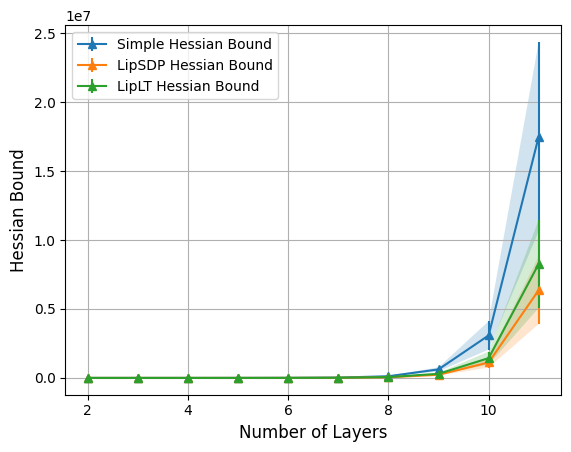

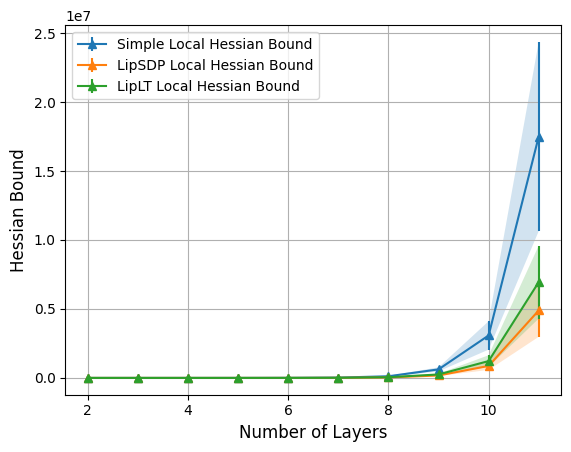

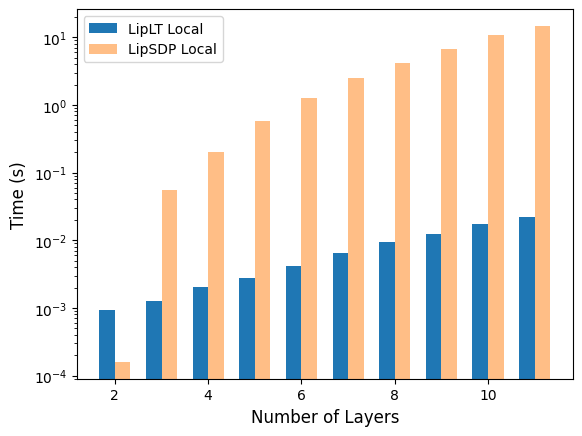

In [16]:
# plt.figure(figsize=(19.2, 4.8))
# plt.subplot(1, 3, 1)

plt.errorbar([i + 2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) ,
              torch.std(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
# plt.plot([i for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
plt.fill_between([i+2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) - torch.std(simpleHessianBoundLayer, dim=1),
                torch.mean(simpleHessianBoundLayer, dim=1) + torch.std(simpleHessianBoundLayer, dim=1), alpha=0.2)


plt.errorbar([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) ,
                torch.std(LipHessianBoundLayer, dim=1), marker='^', label='LipSDP Hessian Bound')
# plt.plot([i for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
plt.fill_between([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) - torch.std(LipHessianBoundLayer, dim=1),
                torch.mean(LipHessianBoundLayer, dim=1) + torch.std(LipHessianBoundLayer, dim=1), alpha=0.2)

plt.errorbar([i+2 for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1) ,
                torch.std(HalfHessionBoundLayer, dim=1), marker='^', label='LipLT Hessian Bound')
# plt.plot([i for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1), marker='^', label='Half Hessian Bound')
plt.fill_between([i+2 for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1) - torch.std(HalfHessionBoundLayer, dim=1),
                torch.mean(HalfHessionBoundLayer, dim=1) + torch.std(HalfHessionBoundLayer, dim=1), alpha=0.2)

plt.ylabel('Hessian Bound', fontsize=12)
plt.xlabel('Number of Layers', fontsize=12)
plt.grid()
plt.legend(loc=2, prop={'size': 10})
plt.savefig('hessian1.pdf')
plt.show()

# plt.subplot(1, 3, 2)

plt.errorbar([i + 2 for i in range(len(simpleLocalHessianBoundLayer[:, 0]))], torch.mean(simpleLocalHessianBoundLayer, dim=1) ,
              torch.std(simpleLocalHessianBoundLayer, dim=1), marker='^', label='Simple Local Hessian Bound')
# plt.plot([i for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
plt.fill_between([i+2 for i in range(len(simpleLocalHessianBoundLayer[:, 0]))], torch.mean(simpleLocalHessianBoundLayer, dim=1) - torch.std(simpleLocalHessianBoundLayer, dim=1),
                torch.mean(simpleLocalHessianBoundLayer, dim=1) + torch.std(simpleLocalHessianBoundLayer, dim=1), alpha=0.2)

plt.errorbar([i+2 for i in range(len(LipLocalHessianBoundLayer[:, 0]))], torch.mean(LipLocalHessianBoundLayer, dim=1) ,
                torch.std(LipLocalHessianBoundLayer, dim=1), marker='^', label='LipSDP Local Hessian Bound')
# plt.plot([i for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
plt.fill_between([i+2 for i in range(len(LipLocalHessianBoundLayer[:, 0]))], torch.mean(LipLocalHessianBoundLayer, dim=1) - torch.std(LipLocalHessianBoundLayer, dim=1),
                torch.mean(LipLocalHessianBoundLayer, dim=1) + torch.std(LipLocalHessianBoundLayer, dim=1), alpha=0.2)


plt.errorbar([i+2 for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1) ,
                torch.std(HalfLocalHessianBoundLayer, dim=1), marker='^', label='LipLT Local Hessian Bound')
# plt.plot([i for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1), marker='^', label='Half Local Hessian Bound')
plt.fill_between([i+2 for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1) - torch.std(HalfLocalHessianBoundLayer, dim=1),
                torch.mean(HalfLocalHessianBoundLayer, dim=1) + torch.std(HalfLocalHessianBoundLayer, dim=1), alpha=0.2)


plt.ylabel('Hessian Bound', fontsize=12)
plt.xlabel('Number of Layers', fontsize=12)
plt.grid()
plt.legend(loc=2, prop={'size': 10})
plt.savefig('hessian2.pdf')
plt.show()


# plt.subplot(1, 3, 3)
clmnwdth = [1 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]
plt.bar(height=torch.mean(torch.vstack(LipLTTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) - torch.Tensor(clmnwdth)/6, 
                width=torch.Tensor(clmnwdth)/3, alpha=1, label='LipLT Local')
plt.bar(height=torch.mean(torch.vstack(LipSDPTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) + torch.Tensor(clmnwdth)/6, 
                width=torch.Tensor(clmnwdth)/3, alpha=0.5, label='LipSDP Local')



plt.ylabel('Time (s)',fontsize=12)
plt.xlabel('Number of Layers', fontsize=12)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc=2, prop={'size': 10})

plt.savefig('hessian3.pdf')
plt.show()

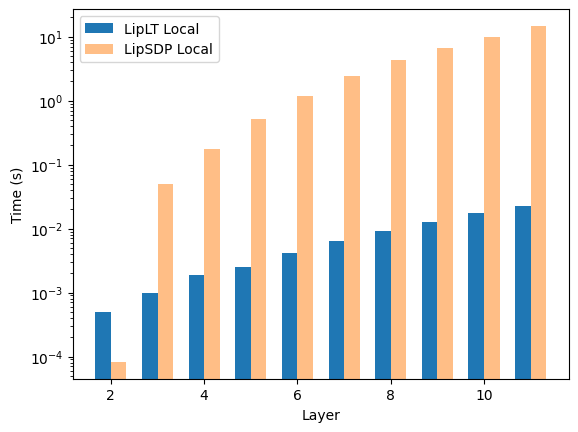

In [7]:
# # clmnwdth = [np.exp(i) / 17 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]
# clmnwdth = [2 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]

# plt.bar(height=torch.mean(torch.vstack(LipLTTime), dim=1), x=torch.mean(HalfLocalHessianBoundLayer, dim=1) - torch.Tensor(clmnwdth)/4, 
#                 width=torch.Tensor(clmnwdth)/2, alpha=1, label='LipLT Local')
# plt.bar(height=torch.mean(torch.vstack(LipSDPTime), dim=1), x=torch.mean(LipLocalHessianBoundLayer, dim=1) + torch.Tensor(clmnwdth)/4, 
#                 width=torch.Tensor(clmnwdth)/2, alpha=0.5, label='LipSDP Local')

clmnwdth = [1 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]
plt.bar(height=torch.mean(torch.vstack(LipLTTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) - torch.Tensor(clmnwdth)/6, 
                width=torch.Tensor(clmnwdth)/3, alpha=1, label='LipLT Local')
plt.bar(height=torch.mean(torch.vstack(LipSDPTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) + torch.Tensor(clmnwdth)/6, 
                width=torch.Tensor(clmnwdth)/3, alpha=0.5, label='LipSDP Local')



plt.ylabel('Time (s)')
plt.xlabel('Layer')
plt.yscale('log')
# plt.xscale('log')
plt.legend()

plt.show()

In [8]:
# plt.figure(figsize=(25, 6))
# plt.subplot(1, 4, 1)

# plt.errorbar([i + 2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) ,
#               torch.std(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
# # plt.plot([i for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
# plt.fill_between([i+2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) - torch.std(simpleHessianBoundLayer, dim=1),
#                 torch.mean(simpleHessianBoundLayer, dim=1) + torch.std(simpleHessianBoundLayer, dim=1), alpha=0.2)

# plt.ylabel('Hessian Bound')
# plt.xlabel('Number of Layers')
# plt.legend()

# plt.subplot(1, 4, 2)
# plt.errorbar([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) ,
#                 torch.std(LipHessianBoundLayer, dim=1), marker='^', label='LipSDP Hessian Bound')
# # plt.plot([i for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
# plt.fill_between([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) - torch.std(LipHessianBoundLayer, dim=1),
#                 torch.mean(LipHessianBoundLayer, dim=1) + torch.std(LipHessianBoundLayer, dim=1), alpha=0.2)

# plt.errorbar([i+2 for i in range(len(LipLocalHessianBoundLayer[:, 0]))], torch.mean(LipLocalHessianBoundLayer, dim=1) ,
#                 torch.std(LipLocalHessianBoundLayer, dim=1), marker='^', label='LipSDP Local Hessian Bound')
# # plt.plot([i for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
# plt.fill_between([i+2 for i in range(len(LipLocalHessianBoundLayer[:, 0]))], torch.mean(LipLocalHessianBoundLayer, dim=1) - torch.std(LipLocalHessianBoundLayer, dim=1),
#                 torch.mean(LipLocalHessianBoundLayer, dim=1) + torch.std(LipLocalHessianBoundLayer, dim=1), alpha=0.2)
# plt.ylabel('Hessian Bound')
# plt.xlabel('Number of Layers')
# plt.legend()

# plt.subplot(1, 4, 3)
# plt.errorbar([i+2 for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1) ,
#                 torch.std(HalfHessionBoundLayer, dim=1), marker='^', label='LipLT Hessian Bound')
# # plt.plot([i for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1), marker='^', label='Half Hessian Bound')
# plt.fill_between([i+2 for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1) - torch.std(HalfHessionBoundLayer, dim=1),
#                 torch.mean(HalfHessionBoundLayer, dim=1) + torch.std(HalfHessionBoundLayer, dim=1), alpha=0.2)

# plt.errorbar([i+2 for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1) ,
#                 torch.std(HalfLocalHessianBoundLayer, dim=1), marker='^', label='LipLT Local Hessian Bound')
# # plt.plot([i for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1), marker='^', label='Half Local Hessian Bound')
# plt.fill_between([i+2 for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1) - torch.std(HalfLocalHessianBoundLayer, dim=1),
#                 torch.mean(HalfLocalHessianBoundLayer, dim=1) + torch.std(HalfLocalHessianBoundLayer, dim=1), alpha=0.2)

# # plt.yscale('log')
# # plt.xscale('log')
# plt.ylabel('Hessian Bound')
# plt.xlabel('Number of Layers')
# plt.legend()


# plt.subplot(1, 4, 4)
# clmnwdth = [1 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]
# plt.bar(height=torch.mean(torch.vstack(LipLTTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) - torch.Tensor(clmnwdth)/6, 
#                 width=torch.Tensor(clmnwdth)/3, alpha=1, label='LipLT Local')
# plt.bar(height=torch.mean(torch.vstack(LipSDPTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) + torch.Tensor(clmnwdth)/6, 
#                 width=torch.Tensor(clmnwdth)/3, alpha=0.5, label='LipSDP Local')



# plt.ylabel('Time (s)')
# plt.xlabel('Layer')
# plt.yscale('log')
# # plt.xscale('log')
# plt.legend()


# plt.show()